In [1]:
# ---------------------------------------------------------------

# ----------------- results general framework

# ---------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os


base_dir = os.path.abspath(os.getcwd() + "/..")

# --- data handling modules

import numpy as np
import pandas as pd
import scipy.io as sp_io
import scipy as sp

# --- visualization modules

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- my modules

methods_dir = base_dir + '/methods/'  
sys.path.insert(0, methods_dir)
from class_sample_selection import sample_selection
import simpls_module



# ¡¡¡ --- !!! # ---> base working directory and available data cases

# # ************************************ init --- user 
caseID_key = "d02_manure"
y_id = 1 # DM
# # ************************************ end --- user 



# # ¡¡¡ --- !!! # ---> data

mat_filename = base_dir + "/data/" + caseID_key +".mat"
data_mat = sp_io.loadmat(mat_filename, struct_as_record = False)



xcal = data_mat["xcal"].copy()
ycal = data_mat["ycal"].copy()[:,[y_id]]
xtest = data_mat["xtest"].copy()
ytest = data_mat["ytest"].copy()[:,[y_id]]
chemical_comp_name = data_mat["y_labels"][y_id]


test_groups = np.ones(xtest.shape[0]).astype(int)

print(xcal.shape)
print(xtest.shape)

print("--- data ready ---")



if "DM" in chemical_comp_name:
    chemical_comp_name_final = "DRY MATTER"



(420, 141)
(164, 141)
--- data ready ---


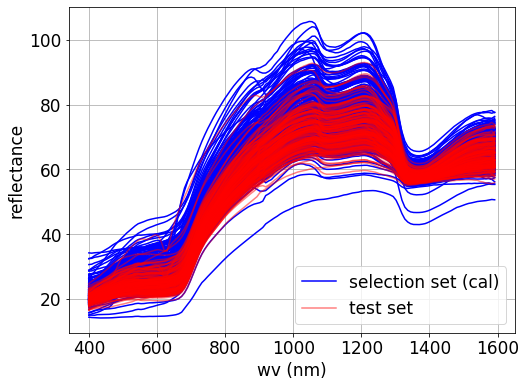

In [2]:
# --- data 

K = xcal.shape[1]
wv_range = np.arange(400,1600,(1600-400)/K)

plt.rcParams.update({'font.size': 17})
plt.subplots(figsize=(8,6))
p1=plt.plot(wv_range,xcal.T, c = "blue")
p2=plt.plot(wv_range,xtest.T, c = "red", alpha = 0.5)
plt.grid()
plt.xlabel("wv (nm)")
plt.ylabel("reflectance")
plt.legend((p1[0],p2[0]), ("selection set (cal)","test set"))

plt.show()

In [3]:
# --- summary table


summary_table_dict = {}

summary_table_dict["selection set (cal)"] = {}
summary_table_dict["selection set (cal)"]["n"] = ycal.shape[0]
summary_table_dict["selection set (cal)"]["Y mean"] = ycal.mean(axis=0)[0]
summary_table_dict["selection set (cal)"]["Y std"] = ycal.std(axis=0)[0]


summary_table_dict["test set"] = {}
summary_table_dict["test set"]["n"] = ytest.shape[0]
summary_table_dict["test set"]["Y mean"] = ytest.mean(axis=0)[0]
summary_table_dict["test set"]["Y std"] = ytest.std(axis=0)[0]

df = pd.DataFrame.from_dict(summary_table_dict, orient="index")
# df.to_clipboard(sep=',')  
df

,n,Y mean,Y std
selection set (cal),420,66.022381,34.717315
test set,164,64.288719,38.514700


In [4]:
# --- initialize numba functions

total_lv = 25
output_pls = simpls_module.simpls_fit(xx=xcal, yy=ycal, ncp=total_lv)
ytest_pred = simpls_module.simpls_predict(xtest,  output_pls[0],output_pls[1],output_pls[2])
rmsep = simpls_module.rmse(ytest, ytest_pred, np.ones(ytest_pred.shape[0]))
r2p = simpls_module.r2(ytest, ytest_pred, np.ones(ytest_pred.shape[0]))
cv_output = simpls_module.simpls_univariate_cv(xx=xcal, yy=ycal, total_ncp=total_lv, number_splits=10)



print("done")

done


In [5]:
# --- get all results

df_design_pls = pd.read_pickle(base_dir + "/scripts_output/" + caseID_key + "_" + chemical_comp_name + "_numba_02_pls_performance.pkl")
method_name = np.unique(df_design_pls["method_name"])
sample_size = np.sort(pd.unique(df_design_pls["sample_size"]))
npc_range = np.sort(np.unique(df_design_pls["npc"]))[:-1]


df_design_pls.shape

(5967, 10)

In [6]:
# --- plot color mapping

import matplotlib as mtply

color_var = np.arange(1,df_design_pls.iloc[0]["rmsecv"].shape[0]+1)
min_color_var = np.amin(color_var)-3
max_color_var = np.amax(color_var)+2

c_m = mtply.cm.hot
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)

ylims_plots = {"rmsep":[9.5, 25], "r2p":[0.1,1.1]} # DM




In [7]:
# group values for plot (b) above

# ************************************
optimal_lv_range = np.arange(11,15)
variable_name = "rmsep"
test_group = 0 # in case there are more test groups
# ************************************


dict_plot = {}

for row_ii in range(df_design_pls.shape[0]):

    df_plot_row = df_design_pls.iloc[row_ii]
    current_sample_size = df_plot_row["selected_samples"].sum()
    plot_values = df_plot_row[variable_name][0]

    for pp in range(optimal_lv_range.shape[0]):
        
        if current_sample_size/optimal_lv_range[pp] in dict_plot.keys():
            dict_plot[current_sample_size/optimal_lv_range[pp]].append(plot_values[optimal_lv_range[pp]-1])
        else:
            dict_plot[current_sample_size/optimal_lv_range[pp]] = [plot_values[optimal_lv_range[pp]-1]]
        

dict_plot_lines = {}

for ss in dict_plot.keys():
    
    dict_plot_lines[ss] = {"ss_d": ss, "min":np.amin(dict_plot[ss]),"max" : np.amax(dict_plot[ss])}
    
dict_plot_lines = pd.DataFrame.from_dict(dict_plot_lines, orient="index")


dict_plot_lines_groups = {}
intervals = np.linspace(np.amin(dict_plot_lines["ss_d"]), np.amax(dict_plot_lines["ss_d"]), 20)

for ii in range(intervals.shape[0]-1):
    
    low_lim = intervals[ii]
    upp_lim = intervals[ii+1]
    
    current_values = dict_plot_lines[(dict_plot_lines["ss_d"]>=low_lim) & (dict_plot_lines["ss_d"]<upp_lim)]
    dict_plot_lines_groups[low_lim] = {"ss_d": low_lim, "min":np.amin(current_values["min"]),"max" : np.amax(current_values["max"])}
    
dict_plot_lines_groups = pd.DataFrame.from_dict(dict_plot_lines_groups, orient="index")


        
print("done")


done


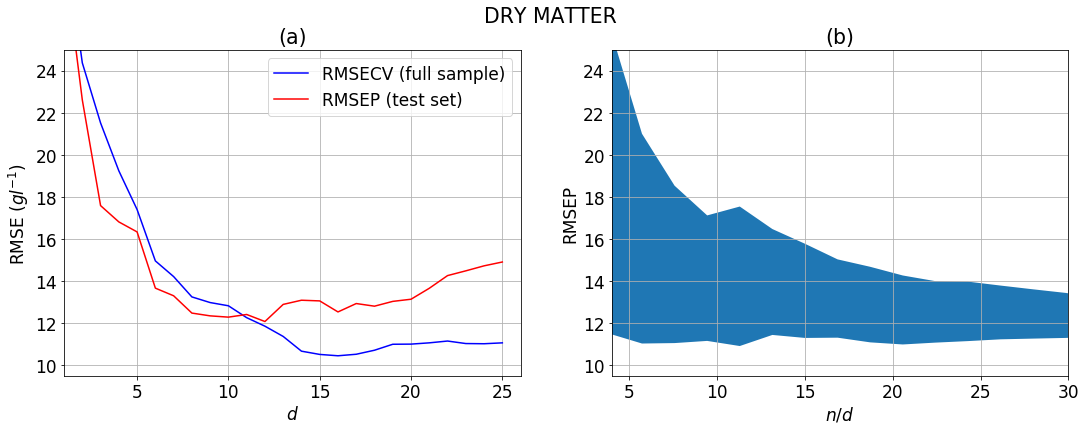

In [8]:
# --- visualization rmse 2


plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))


axs[0].plot(np.arange(1, total_lv+1),cv_output[0], c="blue")
axs[0].plot(np.arange(1, total_lv+1),rmsep[:,0], c = "red")
axs[0].set_title("(a)")
axs[0].set_xlim([1,total_lv+1])
axs[0].set_ylim(ylims_plots[variable_name])
axs[0].set_xlabel("$d$")
axs[0].set_ylabel("RMSE ($gl^{-1}$)")
axs[0].legend(["RMSECV (full sample)", "RMSEP (test set)"])
axs[0].grid()


 
axs[1].fill_between(dict_plot_lines_groups["ss_d"], dict_plot_lines_groups["min"],dict_plot_lines_groups["max"])
        
axs[1].grid()
axs[1].set_xlabel("$n/d$")
axs[1].set_ylabel(variable_name.upper())
axs[1].set_xlim([4,30])
axs[1].set_ylim(ylims_plots[variable_name])
axs[1].set_title("(b)")


plt.suptitle(chemical_comp_name_final.upper())
plt.savefig(base_dir + "/manuscript/figures/" + caseID_key + "_general_framework.png",bbox_inches="tight")
plt.show()